<a href="https://colab.research.google.com/github/lmendezayl/modelado-continuo/blob/main/laboratorios/nb11_DFT%2BFFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> (Última Actualización: 22 de Octubre de 2025)

# **Introducción al modelado continuo** (*a.k.a.* **Ecuaciones de la física matemática**)
## Laboratorio numérico

Bienvenidos al laboratorio numérico de la materia *Introducción al modelado continuo*, también conocida como *Ecuaciones de la física matemática*. En este, vamos a ver métodos numéricos para resolver distintos tipos de problemas de manera general, y su relación y aplicación a problemas específicos de la materia, de manera tal de complementar los contenidos de la cursada teórico-práctica.

# Motivación de este colab
<!-- $$\require{amsmath}$$ -->

La **transformada de Fourier**, en el marco de las transformaciones integrales de variables continuas usando un kernel de Fourier, es una herramienta con grandes aplicaciones en la resolución de problemas de la física matemática con cierto tipo de condiciones de contorno. Permite resolver problemas complicados o incluso que no tienen solución directa, a partir de transformar el problema, resolver el problema en el espacio transoformado, y anti-transformar para encontrar la solución en el espacio original. En la clase teórica vimos como esto nos permitía obtener las soluciones de ecuaciones diferenciales en derivadas parciales (PDEs) a partir de resolver en el espacio transformado ecuaciones diferenciales ordinarias (ODEs), como las que vimos durante el 1er eje temático. Esto nos permitía resolver problemas de sistemas físicos tradicionales como la ecuación del calor o la ecuación de ondas. Así mismo, también vimos que este tipo de estrategias nos permitía resolver de manera parsimoniosa el oscilador forzado, debido a la naturaleza periódica del problema. Entonces, vimos la potencia de la transformada de Fourier en aplicaciones matemáticas para variables continuas.

Ahora, qué pasa cuando tengo una representación discreta de variables, es decir, datos? En este colab vamos a revisar algunos conceptos de la transformada desde la perspectiva numérica, y vamos a explorar la transformada de Fourier en el contexto de aplicación a señales. Vamos a reforzar la interpretación de la transformada de una señal discreta en este marco, y cómo adaptarla. Esto nos va a llevar a definir la **transformada discreta de Fourier (DFT)**, destacando el algoritmo de la **transformada rápida de Fourier (FFT)** como estrategia para poder computarla de manera eficiente y menos costosa.

---


In [ ]:
import numpy as np
np.set_printoptions(legacy='1.25')
import matplotlib.pyplot as plt
!pip install scipy
import scipy as sp

---
# Generalización de series de Fourier para funciones periódicas

En el colab pasado vimos la representación en series de Fourier para funciones periódicas con período $2 \pi$. Estas expansiones se pueden extender a funciones periódicas con período $2L$ con la siguiente expresión:

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n cos \left( \frac{n \pi x}{L} \right) + \sum_{n=1}^{\infty} b_n sin \left( \frac{n \pi x}{L} \right)
$$

Donde los coeficientes están relacionados con la función periódica f(x) mediante integrales definidas:

$$
a_n = \frac{1}{L} \int_{-L}^{L} f(x) cos \left( \frac{n \pi x}{L} \right) dx \\
b_n = \frac{1}{L} \int_{-L}^{L} f(x) sin \left( \frac{n \pi x}{L} \right) dx
$$

El cálculo de los coeficientes se resuelve de manera análoga que para el caso en el que el período es $2 \pi$.

Noten que para generalizar a funciones periódicas con período $2L$ tuvimos que adaptar la periodicidad de las funciones ortogonales de la base de senos y cosenos para que tengan período $2L$ (cambiando la expresión de su argumento), y también tuvimos que cambiar el factor multiplicativo por un tema de normalización de la base.

Las series de Fourier, de manera más general, permiten analizar funciones periódicas de cualquier período, descomponiéndolas en una suma infinita de funciones armónicas. Los coeficientes expresan la cantidad de cada una de las señales armónicas puras que se deben sumar para obtener la señal analizada.


## Ejercicio 1

Sea la función $f_1(x)=sin(\pi x)+2sin(3\pi x)$

1.1. Qué período tiene? Haga el gráfico para varios períodos.

1.2. Calcule los coeficientes del desarrollo de Fourier hasta el orden 8. Haga el gráfico de los coeficientes en función de la frecuencia discreta (o del n, por simplicidad). Es lo que esperaba encontrar? Haga también el gráfico de $\sqrt{a_n^2+b_n^2}$.

1.3. Repita el análisis para $f_2(x)=sin(4\pi x)+2sin(2\pi x)$.


In [ ]:
pi = np.pi
def f1(x): return np.sin(pi*x) + 2*np.sin(3*pi*x)

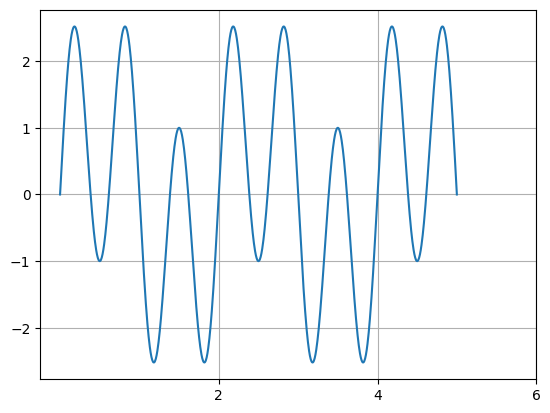

In [ ]:
x = np.linspace(0,5,1000)
y = f1(x)
plt.plot(x, y)
plt.xticks([2,4,6])
plt.grid()

In [ ]:
def coefs(f, L: float | int, dh:int, N: int) -> None:
    coeffs_a: list[float] = list()
    coeffs_b: list[float] = list()
    x = np.linspace(-L, L, dh)
    a_0 = round((1/L) * np.trapezoid(f(x), x) / 2, 5)

    for k in range(1, N):
        a_k: float = (1/L) * np.trapezoid(f(x) * np.cos((k*np.pi*x)/L), x)
        b_k: float = (1/L) * np.trapezoid(f(x) * np.sin((k*np.pi*x)/L), x)
        coeffs_a.append(round(a_k, 5))
        coeffs_b.append(round(b_k, 5))

    plt.plot(coeffs_a, label="$a_n$")
    plt.plot(coeffs_b, label="$b_n$")
    plt.plot([np.sqrt(a**2 + b**2) for a, b in zip(coeffs_a, coeffs_b)], label="$\sqrt{a_n^2+b_n^2}$")
    plt.title(f"Funciοn con periodo {L}")
    plt.grid()
    plt.legend()
    plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2613963048.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.plot([np.sqrt(a**2 + b**2) for a, b in zip(coeffs_a, coeffs_b)], label="$\sqrt{a_n^2+b_n^2}$")


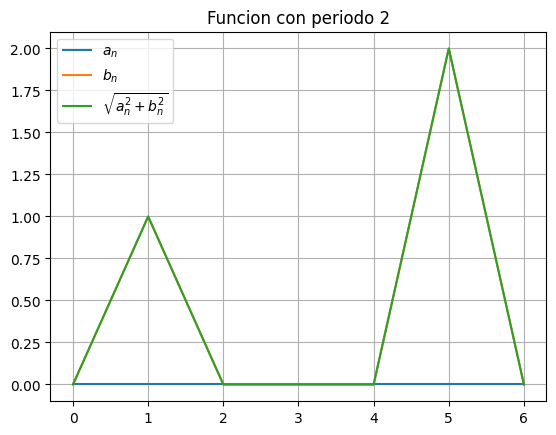

In [ ]:
coefs(f1, 2, 100, 8)

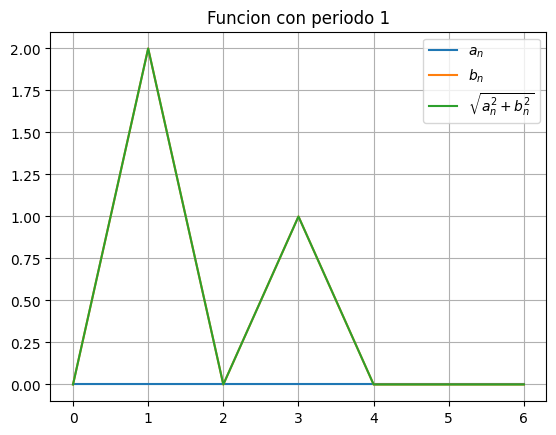

In [ ]:
def f2(x): return np.sin(4*np.pi*x) + 2 * np.sin(2*np.pi*x)
coefs(f2, 1, 100, 8)

---
# Generalización de series de Fourier para funciones no periódicas

De la misma manera que para funciones periódicas, se puede plantear la expansión para funciones no periódicas pero definidas en un intervalo $[-L, L]$, aprovechando las condiciones de contorno del intervalo. Esto se hace extendiendo la función como si se repitiese fuera del intervalo, de manera tal que pueda considerarse a la función como periódica con periodo $2L$. La expansión de Fourier para funciones no periódicas en $[-L, L]$ permite representar cualquier función en ese intervalo mediante una suma infinita de senos y cosenos. Aunque no es una representación extrictamente periódica, su construcción en el intervalo finito implica que, fuera de $[-L, L]$, la función se "extiende" periódicamente. La expansión y los coeficientes se pueden calcular por lo tanto de manera análoga a lo visto para funciones periódicas.

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n cos \left( \frac{n \pi x}{L} \right) + \sum_{n=1}^{\infty} b_n sin \left( \frac{n \pi x}{L} \right) \\
a_n = \frac{1}{L} \int_{-L}^{L} f(x) cos \left( \frac{n \pi x}{L} \right) dx \\
b_n = \frac{1}{L} \int_{-L}^{L} f(x) sin \left( \frac{n \pi x}{L} \right) dx
$$

Los coeficientes representan las amplitudes de las frecuencias $\frac{n \pi}{L}$ que componen la señal.

---
## Paridad de las funciones

La paridad de funciones se refiere a la simetría de una función con respecto al origen o al eje vertical. Una función $f(x)$ es **par** si cumple $f(x) = f(-x)$ para todo $x$, lo que significa que su gráfica es simétrica respecto al eje $y$. En cambio, es **impar** si satisface $f(x) = -f(-x)$, lo que implica que su gráfica es simétrica respecto al origen. Esto hace que las integrales en los intervalos $[-L, 0]$ y $[0, L]$ tengan una relación entre sí. Usando la regla de trapezio compuesta, calculemos las integrales en estos sub-intervalos para varios valores de L distintos, para una función par como $f(x)=x^{2}$, definida en el intervalo $[-L, L]$, y veamos cómo es la relación entre integrales.

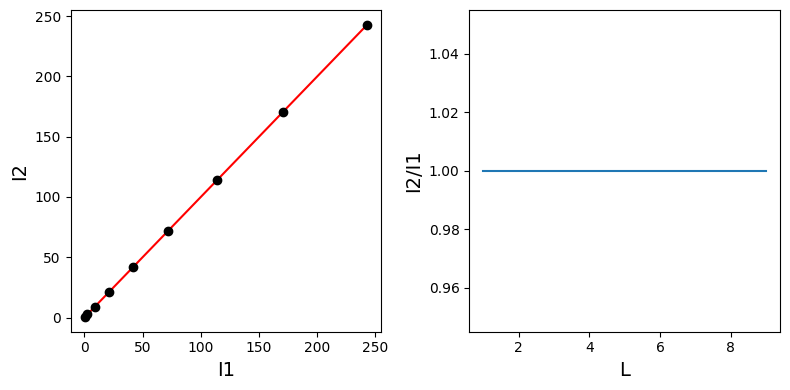

In [ ]:
def f(x):
    return x**2

I1 = []
I2 = []
Ls = np.arange(9)+1
for L in Ls:
    x_mitad1 = np.linspace(-L, 0, 1000)
    I_mitad1 = np.trapezoid(f(x_mitad1), x_mitad1)
    x_mitad2 = np.linspace(0, L, 1000)
    I_mitad2 = np.trapezoid(f(x_mitad2), x_mitad2)
    I1.append(I_mitad1)
    I2.append(I_mitad2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(I1, I1, 'r-')
plt.plot(I1, I2, 'ko')
plt.ylabel('I2', fontsize=14)
plt.xlabel('I1', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(Ls, np.array(I2)/np.array(I1))
plt.ylabel('I2/I1', fontsize=14)
plt.xlabel('L', fontsize=14)
plt.tight_layout()
plt.show()

Veamos qué pasa ahora para una función impar como $f(x)=x^{3}$, definida en el intervalo $[-L, L]$.

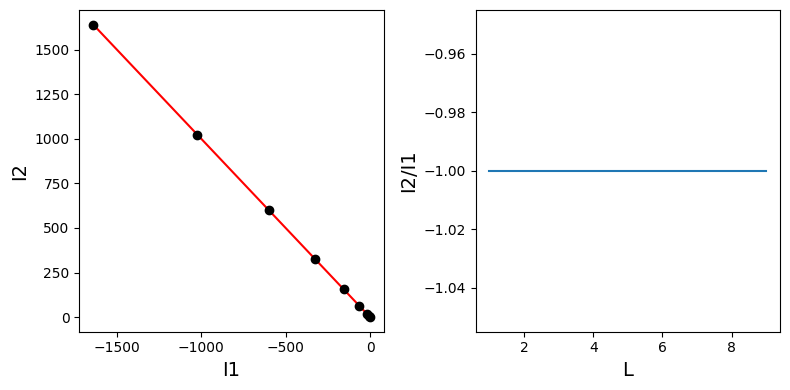

In [ ]:
def f(x):
    return x**3

I1 = []
I2 = []
Ls = np.arange(9)+1
for L in Ls:
    x_mitad1 = np.linspace(-L, 0, 1000)
    I_mitad1 = np.trapezoid(f(x_mitad1), x_mitad1)
    x_mitad2 = np.linspace(0, L, 1000)
    I_mitad2 = np.trapezoid(f(x_mitad2), x_mitad2)
    I1.append(I_mitad1)
    I2.append(I_mitad2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(I1, -np.array(I1), 'r-')
plt.plot(I1, I2, 'ko')
plt.ylabel('I2', fontsize=14)
plt.xlabel('I1', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(Ls, np.array(I2)/np.array(I1))
plt.ylabel('I2/I1', fontsize=14)
plt.xlabel('L', fontsize=14)
plt.tight_layout()
plt.show()

### Ejercicio 2

2.1. Como resultado de esta relación, se muestra que las integrales de funciones impares en el intervalo $[-L,L]$ son 0, ya que las integrales entre $[-L, 0]$ y $[0, L]$ se cancelan entre sí. Compruébelo con la función $f(x)=x^{3}$.

2.2. Usando la regla del trapecio, calcule las integrales de $cos \left( \frac{n \pi x}{L} \right)$ y $sin \left( \frac{n \pi x}{L} \right)$ en el intervalo $[-L, L]$. Espera que alguna sea 0? Piense la respuesta en base a la paridad de las funciones. Es lo que esperaba? Qué es lo que está pasando? Tenga en cuenta que estamos integrando una función trigonométrica armónica exactamente en 1 período. Tengo integrales de funciones pares que se anulan por el hecho de que estoy integrando una función armónica en un período. Para que no sea nula, deberian cambiar el argumento del coseno o los límites de integración para no integrar en un múltiplo entero del período. Pruebe por ejemplo, manteniendo todo igual, modificar sólo los límites de integración para que vayan entre $[-5L/2, 5L/2]$. Entonces, la paridad no es la única razón por la cual algunas integrales se hacen 0, pero siempre ayuda usar estos argumentos de simetría para tener una idea de qué términos del desarrollo sí se cancelan por paridad.

2.3. Calcule ahora tanto para $f(x)=x^{3}$ como para $f(x)=x^{2}$, las integrales

$$
\int_{-L}^{L} f(x) cos \left( \frac{n \pi x}{L} \right) dx \\
\int_{-L}^{L} f(x) sin \left( \frac{n \pi x}{L} \right) dx
$$

Qué resultados espera encontrar? Piense en la paridad de una función $h(x)=f(x).g(x)$ para los casos de distinta paridad de las funciones $f(x)$ y $g(x)$. Para esto piense en los distintos casos cómo quedaría $h(-x)$. Explica esto los resultados obtenidos?

2.4. Qué implicancias tiene esta propiedad en el cálculo de coeficientes del desarrollo de Fourier? Calcule los coeficientes para $f(x)=x^{2}$ y para $f(x)=x^{3}$. Grafique los coeficientes encontrados en función del $n$.

In [ ]:
int_cos = np.

In [ ]:


I1 = []
I2 = []
Ls = np.arange(9)+1
for L in Ls:
    x_mitad1 = np.linspace(-L, 0, 1000)
    I_mitad1 = np.trapezoid(f(x_mitad1), x_mitad1)
    x_mitad2 = np.linspace(0, L, 1000)
    I_mitad2 = np.trapezoid(f(x_mitad2), x_mitad2)
    I1.append(I_mitad1)
    I2.append(I_mitad2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(I1, -np.array(I1), 'r-')
plt.plot(I1, I2, 'ko')
plt.ylabel('I2', fontsize=14)
plt.xlabel('I1', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(Ls, np.array(I2)/np.array(I1))
plt.ylabel('I2/I1', fontsize=14)
plt.xlabel('L', fontsize=14)
plt.tight_layout()
plt.show()

---
# Transformada de Fourier

La **transformada de Fourier** y la expansión de Fourier generalizada están directamente relacionadas. De hecho, la transformada de Fourier es una extensión de la serie de Fourier para funciones no periódicas y no acotadas. Esta extensión surge al considerar el límite de la serie de Fourier de una función cuando el intervalo de periodicidad se hace infinito.

Para entender esta relación, comencemos desde la expansión de Fourier en un intervalo finito $[-L, L]$ para una función $f(x)$:

$$
f(x) = \sum_{n=-\infty}^{\infty} c_n e^{-i \frac{n \pi x}{L}}
$$

donde los coeficientes de Fourier $c_n$ son:

$$
c_n = \frac{1}{2L} \int_{-L}^{L} f(x) e^{i \frac{n \pi x}{L}} \, dx
$$

En esta expresión, las frecuencias $\frac{n \pi}{L}$ son discretas debido al intervalo acotado $[-L, L]$. A medida que $L \to \infty$, el intervalo de definición se extiende a todo el eje real, el período tiende a infinito, y la separación entre las frecuencias $\frac{\pi}{L}$ se vuelve infinitesimal, convirtiendo las frecuencias discretas en un continuo de frecuencias $k$, definidas de la siguiente manera:

$$
k = \frac{n \pi}{L}
$$

Esto implica que cuando $n$ toma valores enteros, $k$ se distribuye de manera discreta en el espacio de frecuencias. En el límite $L \to \infty$, esta frecuencia $k$ se vuelve continua.

Reescribimos entonces $n = \frac{kL}{\pi}$, lo que nos permite reescalar los coeficientes en términos de $k$. Sustituyendo $k = \frac{n \pi}{L}$ en la expresión de $c_n$, obtenemos:

$$
c_n = \frac{1}{2L} \int_{-L}^{L} f(x) e^{i k x} \, dx
$$

En el límite $L \to \infty$, los valores de $k$ se vuelven continuos. La diferencia entre valores consecutivos de $k$ es aproximadamente:

$$
\Delta k = \frac{\pi}{L}
$$

La suma sobre $n$ en la serie de Fourier se convierte entonces en una integral sobre $k$:

$$
\sum_{n=-\infty}^{\infty} c_n e^{-i k x} \approx \int_{-\infty}^{\infty} c(k) e^{-i k x} \, \frac{dk}{\Delta k}
$$

donde $c(k)$ es el valor de $c_n$ asociado a cada $k$, que se interpreta como el espectro de la función.

En este contexto, la función $c(k)$ se define como:

$$
c(k) = \lim_{L \to \infty} \frac{1}{2L} \int_{-L}^{L} f(x) e^{i k x} \, dx
$$

y corresponde a la **transformada de Fourier** de $f(x)$:

$$
\mathcal{F}\{f(x)\} = F(k) = \int_{-\infty}^{\infty} f(x) e^{i k x} \, dx
$$

La expresión de $f(x)$ en términos de su transformada de Fourier es:

$$
f(x) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(k) e^{-i k x} \, dk
$$

De este modo, la transformada de Fourier continua $F(k)$ es una generalización de los coeficientes de Fourier $c_n$ cuando la función se extiende a todo el dominio real ($L \to \infty$).

La transformada de Fourier puede verse como una generalización continua de la expansión de Fourier. Mientras que una serie de Fourier descompone una función periódica en frecuencias discretas, la transformada de Fourier descompone una función no periódica (o periódica en el infinito) en un continuo de frecuencias.

La transformada de Fourier permite analizar funciones en todo el eje real, algo que la serie de Fourier no puede hacer sin imponer periodicidad artificial. Es, en otras palabras, el límite de la expansión de Fourier para funciones no acotadas en un intervalo finito, lo que permite estudiar frecuencias continuas en lugar de discretas.

De esta manera, si consideramos el período $T=2L$, podemos ver los coeficientes $c_n$ de la serie de Fourier como muestras discretas de la transformada de Fourier continua en un conjunto específico de frecuencias $k_n = \frac{n}{T}$:

$$
c_n = \frac{1}{T} F\left(\frac{n}{T}\right)
$$

A medida que $T \to \infty$, los coeficientes $c_n$ se convierten en puntos de la transformada continua, generando un espectro continuo que se vuelve denso en el espacio de frecuencias.


---
# Transformada de Fourier discreta (DFT)

La **transformada de Fourier discreta (DFT)** puede interpretarse como una versión discretizada de la transformada de Fourier (con tiempo y frecuencias discretas), que surge al muestrear tanto en el tiempo como en la frecuencia. Acá es importante diferenciarla de la serie de Fourier para desambiguar y evitar confusiones. La serie de Fourier representa una función en términos de frecuencias discretas, pero continuas en el dominio del tiempo. Por el contrario, la DFT aplica a un conjunto finito de datos (muestras discretas en el tiempo), no a una función continua.

Dada una secuencia discreta de datos $x = [x_0, x_1, \ldots, x_{N-1}]$ de longitud $N$, la DFT de esta secuencia produce otra secuencia de $N$ elementos $X = [X_0, X_1, \ldots, X_{N-1}]$, donde cada $X_k$ representa una frecuencia específica de la señal. La DFT se define como:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{i \frac{2 \pi k n}{N}}
$$

En notación matricial, esto se puede escribir como:

$$
X = W \cdot x
$$

donde $W$ es una **matriz de DFT** de tamaño $N \times N$, cuyas entradas están dadas por:

$$
W_{kn} = e^{i \frac{2 \pi k n}{N}}
$$

Si definimos $\omega = e^{i \frac{2 \pi}{N}}$, entonces $W_{kn} = \omega^{kn}$, y la forma explícita de la matriz $W$ es:

$$
W = \begin{bmatrix}
1 & 1 & 1 & \dots & 1 \\
1 & \omega & \omega^2 & \dots & \omega^{N-1} \\
1 & \omega^2 & \omega^4 & \dots & \omega^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1} & \omega^{2(N-1)} & \dots & \omega^{(N-1)(N-1)}
\end{bmatrix}
$$


## Ejercicio 3

3.1. Escriba una función de Python que reciba como entrada un array y haga el cálculo de la DFT usando el comando `for`.

3.2. Escriba una función de Python que reciba como entrada un array y haga el cálculo de la DFT usando álgebra lineal de matrices.

3.3. Pruebe ambas funciones dándole como entrada vectores aleatorios de 128, 512, y 1024 de largo. Para cada uno de los casos, calcule y compare los tiempos de cómputo.


In [ ]:
def DFT(x: np.ndarray) -> np.ndarray:
    X: np.ndarray
    N = len(x)
    W = np.ones((N, N))

    return X

## Ejercicio 4

Encuentre la DFT de los siguientes vectores:
a) [0,1,0,−1]; b) [1,1,1,1]; c) [0,−1,0,1]; d) [0,1,0,−1,0,1,0,−1]

In [ ]:
# # # COMPLETAR

---
# Transformada Rápida de Fourier (FFT)

La FFT es una implementación eficiente de la DFT, que reduce significativamente el tiempo de cálculo. Uno de los algoritmos más utilizados para la FFT es el algoritmo de Cooley-Tukey propuesto en 1965. La DFT directa requiere $O(N^2)$ operaciones, mientras que la FFT reduce esto a $O(N \log N)$, haciéndola mucho más eficiente para señales largas. De hecho, cuando el N es muy grande, escala “casi linealmente” con el tamaño de N.

El algoritmo consiste básicamente en la aplicación de la estrategia *divide & conquer*, que divide la secuencia original en secuencias cada vez más chicas y las transforma recursivamente. Esto lo hace separando la señal en las componentes pares e impares, y calculando la DFT de cada mitad. Esto se repite recursivamente y, finalmente, se combinan los resultados para obtener la transformada completa.

Si tengo la transoformada X de un vector x, de tamaño N, puedo reescribirlo como:

$$
X = W_N . x = \begin{bmatrix}
I_{N/2} & -D_{N/2} \\
I_{N/2} & -D_{N/2} \\
\end{bmatrix} \begin{bmatrix}
W_{N/2} & 0 \\
0 & W_{N/2} \\
\end{bmatrix}
\begin{bmatrix}
x_{pares} \\
x_{impares} \\
\end{bmatrix}
$$

con

$$
D_N = \begin{bmatrix}
1 & 0 & 0 & \dots & 0 \\
0 & \omega & 0 & \dots & 0 \\
0 & 0 & \omega^2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & \omega^{(N-1)}
\end{bmatrix}
$$

Esto se puede repetir recursivamente, hasta llegar a $W_2$, permitiendo un mecanismo simple de la resolución del problema.

De esta manera, el algoritmo se plantea para valores de N que son potencias de 2, tal que se puedan separar de a mitades. Pero incluso si N no es una potencia de 2, se pueden completar los datos con ceros hasta llegar a la potencia de 2 más cercana y usar este algoritmo, que seguirá siendo una estrategia más eficiente que computar la DFT de manera directa.

Además de la bibliografía recomendada [Arfken et al 2012; Sauer 2012; Brunton & Kutz 2019], pueden encontrar material complementario en los siguientes links acerca de la [interpretación visual de la transformada](https://www.youtube.com/watch?v=h4PTucW3Rm0); la [historia de la FFT](https://www.youtube.com/watch?v=nmgFG7PUHfo); una [explicación de la FFT](https://www.youtube.com/watch?v=toj_IoCQE-4&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC); una [explicación más detallada de la FFT con la estrategia divide and conquer](https://www.youtube.com/watch?v=h7apO7q16V0); una [explicación mucho más detallada](https://www.youtube.com/watch?v=iTMn0Kt18tg) (las últimas 2 son un poco excesivas).


Veamos una forma de escribir el código de la función y comparemos el resultado con el obtenido de la función de Numpy

In [ ]:
def fft_cod(x):
    N = len(x)
    if N <= 1:
        return x
    else:
        X_even = fft_cod(x[0::2])
        X_odd = fft_cod(x[1::2])
        factor = np.exp(2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even - factor[:N // 2] * X_odd])

In [ ]:
x = np.random.random(1024)

# Verificación de la implementación
X_fft = fft_cod(x)
X = np.fft.fft(x)
print("FFT calculada recursivamente:", X_fft)
print("FFT con numpy:", X)  # Comparación con la función de NumPy


Acá observamos una diferencia entre ambos resultados en el signo de la parte compleja. Esto se debe a que numpy usa la convención de signo del exponente en el kernel de Fourier contraria a la que vimos en clase, que está basada en el libro de Arfken.

La **fase** del número complejo que sale de la FFT describe el desfase de cada componente de frecuencia con respecto al origen. Esto puede ser importante para el procesamiento de señales, pero sobre todo para la reconstrucción de la señal original.

Sin embargo, la amplitud de cada componente de frecuencia va a estar descrita únicamente por el **módulo** del número complejo que sale de la FFT, por lo que ese es el resultado que nos interesa para analizar la intensidad de las diferentes frecuencias en la señal.


In [ ]:
# Verificación de la implementación a partir de comparación de los módulos
print("FFT calculada recursivamente:\n", abs(X_fft))
print("FFT con numpy:\n", abs(X))  # Comparación con la función de NumPy

---
## Complejidad del método

La DFT directa requiere $O(N^2)$ operaciones, mientras que la FFT reduce esto a $O(N \log N)$.

### Ejercicio 5

Piense una manera de mostrar diferencias en el costo computacional de la DFT y la FFT. Pruebela. Una idea podría ser evaluar ambos métodos para distintos tamaños de vectores de entrada generados de manera random.

In [ ]:
# # # COMPLETAR

---
# Aliasing

El aliasing es un fenómeno que ocurre cuando una señal continua se muestrea a una tasa insuficiente, resultando en la superposición de frecuencias y la pérdida de información. Según el [teorema de muestreo de Nyquist-Shannon](https://es.wikipedia.org/wiki/Teorema_de_muestreo_de_Nyquist-Shannon), para evitar aliasing, la frecuencia de muestreo debe ser al menos el doble de la frecuencia máxima presente en la señal.

Si una señal tiene una frecuencia máxima de $f_{max}$, la frecuencia de muestreo $f_s$ debe cumplir:

$$
f_s \geq 2 f_{max}
$$

Si esto no se cumple, las frecuencias altas se "aliasan" y aparecen como frecuencias más bajas en el dominio muestreado.

## Ejercicio 6

Considerar una grilla del intervalo $[0,1]$, de paso $\frac{1}{8}$.
- Hacer un scatter plot de los valores de las funciones $f_1(x) = \sin(2\pi x)$ y $f_2(x) = \sin(18\pi x)$ sobre la	grilla. ¿Qué se observa?
- Sobre el scatter plot anterior graficar, usando una grilla más fina (de 1/512), ambas funciones.

In [ ]:
# # # COMPLETAR

---
# Uso de la FFT

En Python, `numpy` proporciona `np.fft.fft` para calcular la FFT de manera rápida y sencilla.

Al usar esta función para transformar una señal a su representación en frecuencia, obtendremos valores complejos representando la magnitud y fase de cada frecuencia de la señal. Para representar la amplitud de las frecuencias, usamos el módulo de los valores complejos devueltos por la FFT.

Es importante que la **frecuencia de muestreo** (fs) sea al menos el doble de la frecuencia máxima de la señal para cumplir con el teorema de Nyquist. Si la frecuencia de muestreo es insuficiente, se produce **aliasing**, y las componentes de frecuencia más altas se reflejan como componentes de frecuencia más bajas, distorsionando la señal.

La FFT nos da tantos valores como puntos tenga la señal. Sin embargo, sólo la primera mitad de los valores representa frecuencias únicas (debido a la **simetría de la transformada**). Para interpretar la FFT, necesitamos generar un eje de frecuencias. Para visualizar correctamente, normalmente usamos sólo la primera mitad de los resultados, ya que en la FFT de una señal real, los valores de la segunda mitad son simétricos de los de la primera mitad.




In [ ]:
# Parámetros de la señal
fs = 500 # frecuencia de muestreo (Hz)
D = 1.0 # duración de la señal (s)
t = np.arange(0, D, 1/fs) # vector de tiempo

# Señal con dos frecuencias
f1, f2 = 50, 120
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

# Calculamos la FFT
fft_values = np.fft.fft(signal)
# Número total de puntos de la señal
N = len(signal)
# Eje de frecuencias
freqs = np.fft.fftfreq(N, 1/fs)

# Tomamos sólo la primera mitad debido a la simetría
fft_values_half = fft_values[:N//2]
freqs_half = freqs[:N//2]

# Magnitud de la FFT
magnitude = np.abs(fft_values_half)

# Visualizamos la señal original y su espectro de frecuencias
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title("Señal en el dominio del tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.subplot(2, 1, 2)
plt.plot(freqs_half, magnitude)
plt.title("Espectro de frecuencias (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")

plt.tight_layout()
plt.show()

## Ejercicio 7

Genere una onda cuadrada de cierta periodicidad, y encuentre el espectro discreto de Fourier usando `np.fft.fft`. Tenga en cuenta las consideraciones correspondientes sobre la frecuencia de muestreo y la frecuencia de la onda, y sobre cómo usar la función de Numpy.


In [ ]:
# # # COMPLETAR

---
# Aplicaciones matemáticas

## Cálculo de la derivada

Una aplicación matemática de la transformada de Fourier es calcular la derivada de una función. La transformada de Fourier es útil para calcular derivadas porque en el dominio de frecuencias, derivar se convierte en una operación de multiplicación. Esto surge de cómo la derivada afecta a las funciones exponenciales complejas, que son las bases de Fourier.

Dada una función $f(x)$, su transformada de Fourier $F(k)$ está definida por:

$$
F(k) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(x) e^{ikx} \, dx
$$

Para volver a la función original podemos antitransformar, por lo que la función se puede expresar de la siguiente manera:

$$
f(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} F(k) e^{-ikx} \, dk
$$

Si queremos calcular la derivada $f'(x)$ en el dominio de Fourier, usamos que:

$$
\frac{d}{dx} f(x) \rightarrow -ik F(k)
$$

Esto se deriva de la propiedad de derivación en Fourier: si derivamos una función en el dominio real, su transformada de Fourier se multiplica por $(-ik)$. Así, la transformada de Fourier de $f'(x)$ es simplemente $(-ik) \cdot F(k)$. Para calcular $f'(x)$, entonces:

1. Calculamos $F(k)$ con la FFT.
2. Multiplicamos $F(k)$ por $(-ik)$ para obtener la transformada de $f'(x)$.
3. Aplicamos la transformada inversa de Fourier para regresar al dominio real y obtener $f'(x)$.

Esta propiedad se extiende a derivadas de orden superior: cada derivada agrega un factor $(-ik)^n$ en el dominio de Fourier.

El método de derivación mediante FFT es más preciso para funciones periódicas debido a la naturaleza de la FFT, que asume implícitamente periodicidad en el intervalo de análisis. Para funciones periódicas, este método es exacto dentro del intervalo de un período, ya que la FFT representa fielmente sus componentes de frecuencia sin efectos indeseados en los bordes. Para funciones que no son periódicas, la FFT aplica una extensión periódica, lo que puede introducir discontinuidades en los bordes del intervalo. Esto genera errores en el cálculo de la derivada, conocidos como *artefactos de borde*. Para minimizar estos efectos en funciones no periódicas, una estrategia común es extender el intervalo de manera que la función "parezca" más periódica, o también se puede suavizar los bordes (por ejemplo, con una ventana de Hann o de Hamming) antes de aplicar la FFT, aunque esto puede disminuir la precisión en los extremos del intervalo.


**Ejemplo**

Consideremos una función cuadrática $f(x)=x^{2}$ en un intervalo $[-L, L]$, evaluada en puntos equiespaciados. La derivada de esta función puede calcularse en el dominio de la frecuencia multiplicando cada coeficiente de frecuencia por $(-ik)$.

Esto se debe a que se puede plantear el cálculo de derivadas de funciones utilizando la propiedad:
$$
F'(k) = - 2\pi i k F(k)
$$

Para ello debemos tener en cuenta varias cosas:
- En el caso discreto trabajamos sobre un intervalo acotado (de longitud $L$ que tomaremos como el período de la función).
- La variable $k$ también es discreta y debemos tomar en cuenta su rango.
- Cuando usamos la FFT de Numpy, tenemos que redefinir la convención de la transformada tal que en lugar de $(-ik)$ usamos $ik$.

La fórmula, por lo tanto se transforma en:
$$
F(f')[k] = \frac{2\pi}{L}i k F(f)[k],
$$

donde $F$ es la transformada discreta y $k=-\frac{N}{2},\dots,\frac{N}{2}-1$.


In [ ]:
def f(x):
    return x**2

L = 2  # Longitud del intervalo [-L, L]
N = 1024  # Número de puntos de muestreo (potencia de 2 para mayor eficiencia en FFT)
# Discretización del dominio
x = np.linspace(-L, L, N, endpoint=False)
dx = x[1] - x[0]  # Paso de discretización
# Evaluación de la función
f_x = f(x)
# Aplicamos la FFT
f_hat = np.fft.fft(f_x)
# Números de onda
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
# Derivada en el dominio de Fourier (multiplicación por ik)
f_hat_deriv = 1j * k * f_hat
# Transformada inversa para obtener la derivada en el dominio real
f_x_deriv = np.fft.ifft(f_hat_deriv).real
# Valor teórico de la derivada para comparar
f_deriv_exact = 2 * x
# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(x, f_deriv_exact, label="Derivada exacta $f'(x) = 2x$", color='blue')
plt.plot(x, f_x_deriv, '--', label="Derivada con FFT", color='orange')
plt.legend()
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.title("Cálculo de la derivada de $f(x) = x^2$ usando FFT")
plt.grid()
plt.show()


Al observar el gráfico, se nota que la derivada calculada usando la FFT coincide con la derivada teórica de $f(x)=x^{2}$, que es $f'(x)=2x$. Esta aplicación demuestra cómo la DFT puede ser útil en la resolución de problemas matemáticos.

### Ejercicio 8

Para un $N$ que sea potencia de 2, calcular las derivadas de las siguientes funciones.
- $f(x) = sin(x)$, en $[0,2\pi]$
- $f(x) = x$, en $[0,1]$

Para ello, definir una grilla de algún intervalo adecuado, evaluar la función, aplicarle la función `fft` de Numpy, multiplicar y aplicar la transformada inversa (también con Numpy, buscar documentación). A la hora de multiplicar, tener en cuenta que los coeficientes no necesariamente se encuentran en el orden esperado.

In [ ]:
# # # COMPLETAR

## Operador lineal

La transformada de Fourier es un operador lineal, ya que satisface la propiedad de linealidad: para dos funciones $f(x)$ y $g(x)$ y constantes $a$ y $b$, se cumple que

$$
\mathcal{F}\{a. f(x) + b. g(x)\} = a. \mathcal{F}\{f(x)\} + b. \mathcal{F}\{g(x)\}
$$

Esto significa que la transformada de Fourier preserva la suma de funciones y la multiplicación por constantes, una propiedad fundamental en su aplicación a sistemas lineales.


In [ ]:
def is_linear(operator, x, y, alpha, beta):
  result1 = operator(alpha * x + beta * y)
  result2 = alpha * operator(x) + beta * operator(y)
  return np.allclose(result1, result2)

# Ejemplo de uso
x = np.random.rand(128)
y = np.random.rand(128)
alpha = 2.5
beta = -1.2

# La función np.fft.fft es la FFT de NumPy
if is_linear(np.fft.fft, x, y, alpha, beta):
  print("La transformada de Fourier es un operador lineal.")
else:
  print("La transformada de Fourier no es un operador lineal.")